In [ ]:
# Install required libraries
!pip install transformers datasets torch accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
# Load dataset from Hugging Face
from datasets import load_dataset

ds = load_dataset("UniqueData/customers-reviews-on-banks")
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Banks.csv:   0%|          | 0.00/11.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19271 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['author', 'date', 'location', 'bank', 'star', 'text', 'like'],
        num_rows: 19271
    })
})

In [ ]:
# Create sentiment labels from star ratings
df = ds["train"].to_pandas()

def map_sentiment(rating):
  if rating in [1, 2]:
    return "Negative"
  elif rating == 3:
    return "Neutral"
  else:
    return "Positive"
df["sentiment"] = df["star"].apply(map_sentiment)

df.head()

,author,date,location,bank,star,text,like,sentiment
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,NaN,Positive
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,NaN,Positive
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0,Positive
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0,Positive
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0,Positive


In [ ]:
# Turn sentiment strings into numeric labels
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["label"] = df["sentiment"].map(label_map)

df[["star", "sentiment", "label"]].head()

,star,sentiment,label
0,5,Positive,2
1,5,Positive,2
2,4,Positive,2
3,5,Positive,2
4,5,Positive,2


In [ ]:
# Check mapping
df["sentiment"].value_counts(normalize=True) * 100
df["label"].value_counts(normalize=True) * 100

,proportion
label,
0,88.760313
2,9.724456
1,1.515230


In [ ]:
# Compute class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0,1,2])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df["label"]
)

class_weights

array([ 0.37554321, 21.99885845,  3.42778371])

In [ ]:
# Convert dataframe back to huggingface dataset
from datasets import Dataset

hf_dataset = Dataset.from_pandas(df)

hf_dataset

Dataset({
    features: ['author', 'date', 'location', 'bank', 'star', 'text', 'like', 'sentiment', 'label'],
    num_rows: 19271
})

In [ ]:
# Train/validation split
train_valid = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_ds = train_valid["train"]
valid_ds = train_valid["test"]

train_ds, valid_ds

(Dataset({
     features: ['author', 'date', 'location', 'bank', 'star', 'text', 'like', 'sentiment', 'label'],
     num_rows: 15416
 }),
 Dataset({
     features: ['author', 'date', 'location', 'bank', 'star', 'text', 'like', 'sentiment', 'label'],
     num_rows: 3855
 }))

In [ ]:
# Tokenize for BERT
from transformers import BertTokenizerFast

model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

max_length = 128

def tokenize(batch):
    texts = ["" if t is None else str(t) for t in batch["text"]]
    labels = [int(l) for l in batch["label"]]

    tokens = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

    tokens["labels"] = labels
    return tokens

tokenized_train = train_ds.map(tokenize, batched=True)
tokenized_valid = valid_ds.map(tokenize, batched=True)

tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_valid.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/15416 [00:00<?, ? examples/s]

Map:   0%|          | 0/3855 [00:00<?, ? examples/s]

In [ ]:
# Create BERT model with class-weighted loss
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1, 2])  # Negative, Neutral, Positive

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df["label"]
)

print("Class weights:", dict(zip(classes, class_weights)))

Class weights: {np.int64(0): np.float64(0.37554321348533565), np.int64(1): np.float64(21.998858447488583), np.int64(2): np.float64(3.427783706865884)}


In [ ]:

import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support

num_labels = 3
model_name = "bert-base-uncased"

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# put class weights on the same device as the model (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cw = torch.tensor(class_weights, dtype=torch.float, device=device)

# ---- metrics: precision, recall, F1 (macro) ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0
    )

    return {
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1
    }

# ---- custom Trainer that applies class-weighted loss ----
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# ---- training args ----
batch_size = 16

training_args = TrainingArguments(
    output_dir="./bert-banks-sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support

num_labels = 3
model_name = 'bert-base-uncased'

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Put class weights on same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cw = torch.tensor(class_weights, dtype=torch.float, device=device)

# Metrics: precision, recall, F1 (macro)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0
    )

    return {
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1
    }

# Custom trainer that applies class-weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self,
                     model,
                     inputs,
                     return_outputs=False,
                     num_items_in_batch=None,
                     **kwargs
    ):

        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Training args
batch_size = 16

training_args = TrainingArguments(
    output_dir="./bert-banks-sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    push_to_hub=False,

)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro
1,0.685100,0.845733,0.815701,0.647296,0.632640
2,0.526600,1.113036,0.799345,0.656479,0.687983
3,0.293200,1.074848,0.717738,0.686492,0.699658


{'eval_loss': 1.0748481750488281,
 'eval_precision_macro': 0.717737601982828,
 'eval_recall_macro': 0.6864924657729788,
 'eval_f1_macro': 0.6996582856182467,
 'eval_runtime': 26.7525,
 'eval_samples_per_second': 144.099,
 'eval_steps_per_second': 9.008,
 'epoch': 3.0}

In [ ]:
from sklearn.metrics import classification_report, f1_score

preds = trainer.predict(tokenized_valid)
y_pred = preds.predictions.argmax(axis=-1)
y_true = preds.label_ids

# Macro F1 headline number
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
print("Macro F1:", macro_f1)

# Full report
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Negative", "Neutral", "Positive"],
        zero_division=0
    )
)

Macro F1: 0.6996582856182467
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99      3436
     Neutral       0.26      0.18      0.21        68
    Positive       0.92      0.89      0.90       351

    accuracy                           0.97      3855
   macro avg       0.72      0.69      0.70      3855
weighted avg       0.96      0.97      0.97      3855



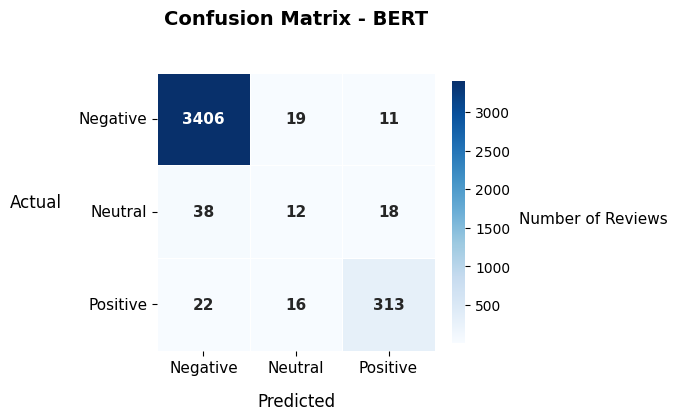

In [ ]:
!pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['Negative', 'Neutral', 'Positive']

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 11, "weight": "bold"},
    linewidths=0.7,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Number of Reviews"}
)

# Define title, labels, ticks and cbar
plt.title("Confusion Matrix - BERT", fontsize=14, weight='bold', pad=35)
plt.xlabel("Predicted", fontsize=12, labelpad =12)
plt.ylabel("Actual", fontsize=12, labelpad=12, rotation=0, ha='right')
plt.xticks(fontsize=11)
plt.yticks(rotation=0, fontsize=11)


# Make colourbar label horizontal
cbar = plt.gcf().axes[-1]
cbar.set_ylabel("Number of Reviews", rotation=0, labelpad=60, fontsize=11)
cbar.yaxis.set_label_position('right')

plt.gca().set_facecolor("#F7F9FB")
plt.tight_layout()
plt.show()